In [1]:
#|default_exp benchmarking.sign_prediction
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
# jax.default_device = jax.devices("cpu")

[CpuDevice(id=0)]

# Sign Prediction Tests
> Comparisons between Diffusion Curvature and the Competition

Here we employ saddles and spheres of increasing dimension to test our model's ability to detect sign.

# Machinery

In [2]:
#|export
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

In [5]:
#|export
from tqdm.auto import tqdm, trange
from fastcore.all import *
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *
from diffusion_curvature.kernels import tune_curvature_agnostic_kernel

method_name = "Diffusion Curvature (Denoising)"

def run_sadspheres(
):
    SS1 = SadSpheres(
        dimension = dims, # Dimension of saddles and spheres
        num_pointclouds = num_pointclouds, # num pointclouds to make in total
        num_points = 2000, # num points per pointclouds
        noise_level = 0, # from 0 to 1. 1 is all noise.
        include_planes=True,
    )
    known_dim_bandwidths = {}
    if method_name in SS1.imported_methods:
        return SS1
    for X in tqdm(SS1):
        dim = X.shape[1] - 1
        if dim not in known_dim_bandwidths.keys():
            kernel, ns = tune_curvature_agnostic_kernel(X, 120, tolerance = 5, max_iterations = 100, alpha = 0)
            known_dim_bandwidths[dim] = kernel
        DC = DiffusionCurvature2(
            graph_former = known_dim_bandwidths[dim],
            comparison_space_trials = 10,
        )
        ks = DC.fit(X, dim = X.shape[1] - 1, ts = list(range(1,84)))
        SS1.update(ks[0].item(), method_name = method_name)
    SS1.save_results()
    return SS1

In [6]:
SS1 = run_sadspheres()

Loaded evaluations on methods ['ground truth', 'Hickok & Blumberg', 'Diffusion Curvature', 'Ollivier Ricci', 'Forman Ricci']


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
to_delete = ['Diffusion Curvature (Trajectory Normalized w/ Anisotropy)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)', 'Diffusion Curvature (TN w/ k = 1 consistent adaptive n 18 t 84)', 'Diffusion Curvature (TN w/ k = 1 consistent adaptive n 40 t 84)', 'Diffusion Curvature (TN w/ k = 1 consistent adaptive n 80 t 84)', 'Diffusion Curvature (TN w/ k = 1 consistent adaptive n 120 t 84)', 'Diffusion Curvature (TN w/ ca n 120 t 84 trials 10)', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)']
for name in to_delete:
    SS1.delete_saved_method(name)
SS1.save_results()

Deleted method from saved results
Deleted method from saved results
Deleted method from saved results
Deleted method from saved results
Deleted method from saved results
Deleted method from saved results
Deleted method from saved results
Deleted method from saved results
Deleted method from saved results


In [7]:
SS1.table()

ks
                                 pearson_r  sign_score
ground truth                      1.000000       1.000
Hickok & Blumberg                 0.031123       0.600
Diffusion Curvature               0.754211       0.965
Ollivier Ricci                    0.032229       0.500
Forman Ricci                      0.877403       0.500
Diffusion Curvature (Denoising)   0.329290       0.600


{'ks':                                  pearson_r  sign_score
 ground truth                      1.000000       1.000
 Hickok & Blumberg                 0.031123       0.600
 Diffusion Curvature               0.754211       0.965
 Ollivier Ricci                    0.032229       0.500
 Forman Ricci                      0.877403       0.500
 Diffusion Curvature (Denoising)   0.329290       0.600}

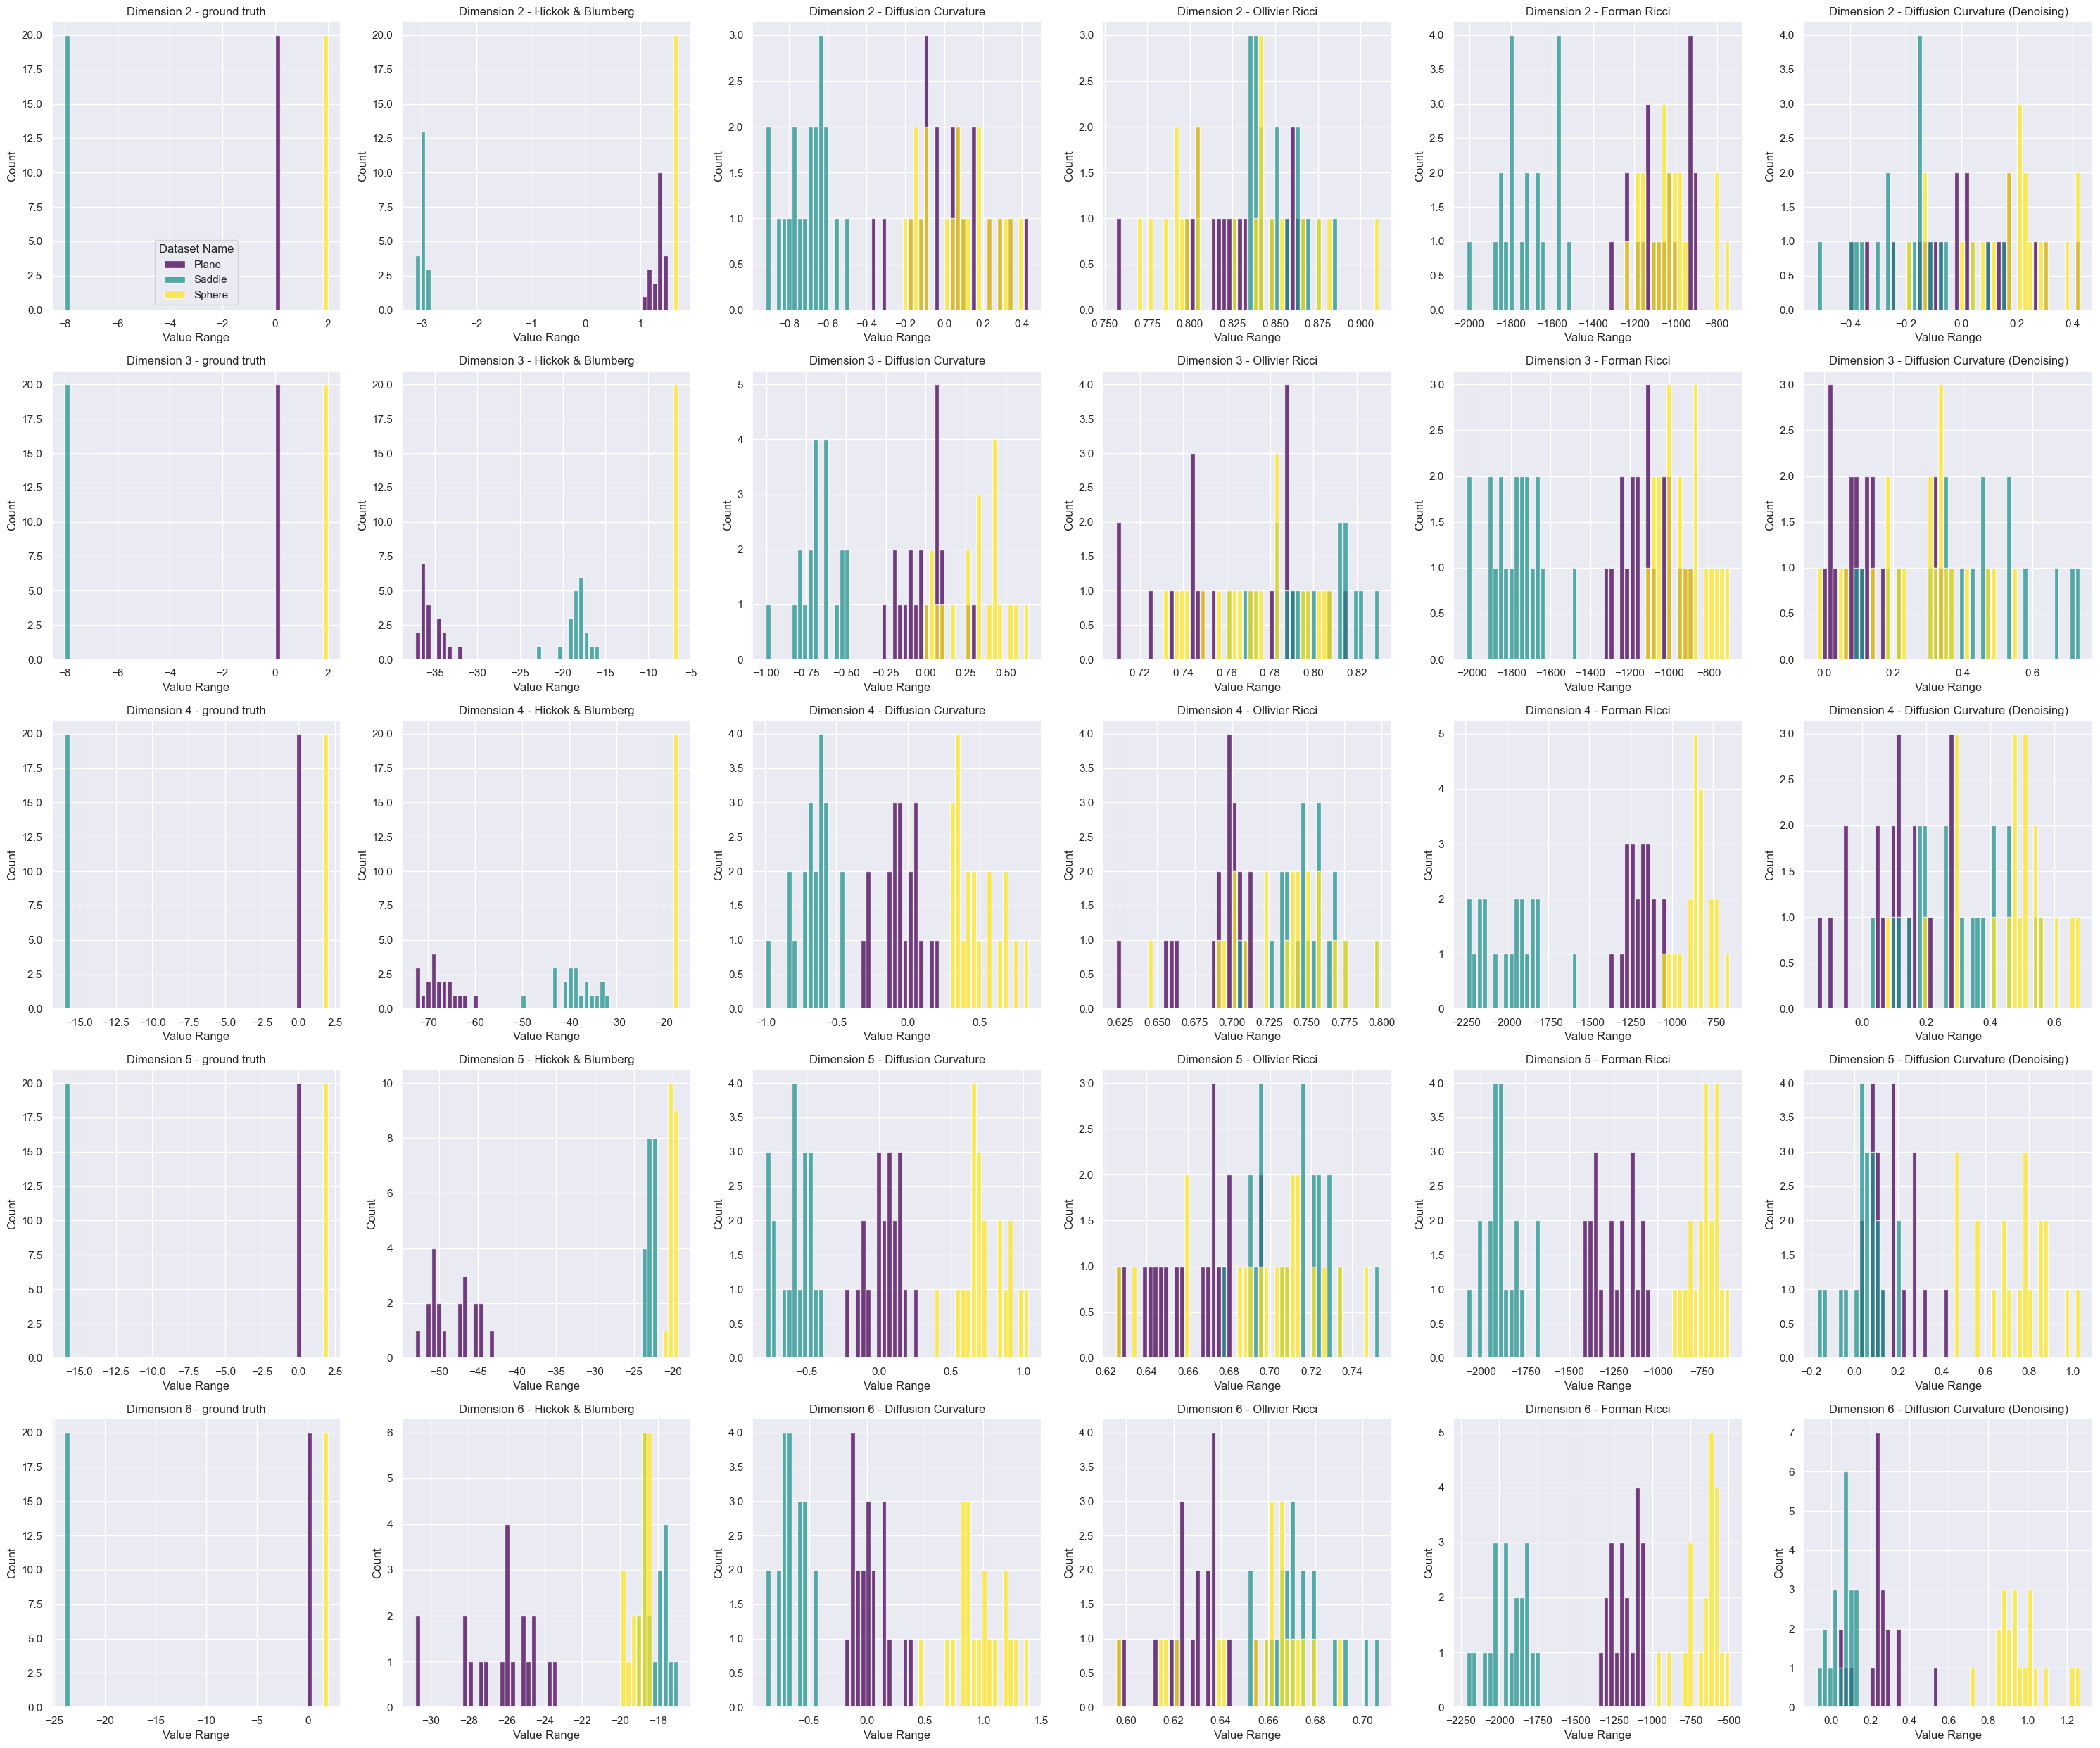

In [8]:
#| label: fig-sadspheres
#| fig-cap: Predicted curvatures of Saddles and Spheres in dimensions 2-6. Diffusion Curvature robustly distinguishes between the signs of the data, even in high dimensions, and with relative sparsity.
#| fig-alt: ...
SS1._aggregate_labels()
SS1.plot_by_dimension()

In [ ]:
SS1.metric_tables['ks'][SS1.metric_tables['ks'].keys()[0]]['ground truth']

1.0

In [ ]:
SS1.get_score('Hickok & Blumberg', 'pearson_r')

0.0311233206615215

In [ ]:
# graph_former = partial(get_curvature_agnostic_graph, k = dim*2, )
from diffusion_curvature.kernels import tune_curvature_agnostic_kernel
graph_former = partial(get_fixed_graph, sigma = 0.2, alpha = 1)
for X in tqdm(SS1):
    if "Diffusion Curvature (Entropic)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Wasserstein",
            flattening_method="Fixed",
            comparison_method="Ollivier",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Entropic)")
    if "Diffusion Curvature (Wasserstein)" not in SS1.imported_methods:
        G = graph_former(X)
        DC = DiffusionCurvature(
            laziness_method="Entropic",
            flattening_method="Fixed",
            comparison_method="Subtraction",
            graph_former = graph_former,
            points_per_cluster=None,  # construct separate comparison spaces around each point
            comparison_space_size_factor=1,
        )
        ks = DC.curvature(G, dim = X.shape[1] - 1, t = 25)
        SS1.update(ks[0], method_name="Diffusion Curvature (Wasserstein)")
    if "Diffusion Curvature (TN w/ k = 1 adaptive n t 40)" not in SS1.imported_methods:
        kernel, ns = tune_curvature_agnostic_kernel(X, 20, tolerance = 5)
        DC = DiffusionCurvature2(
            graph_former = kernel
        )
        ks = DC.fit(X, dim = X.shape[1] - 1, idx = 0, ts = list(range(1,40)))
        SS1.update(ks.item(), method_name = "Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)")

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Parameter Optimization

In [ ]:
#|export
import optuna
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        # 'laziness_method': trial.suggest_categorical('laziness_method', ['Entropic']),
        'anisotropy': trial.suggest_float('anisotropy', 0, 1, step = 0.1),
        # 'k' : trial.suggest_int('k', 1, 10),
        # 'neighbor_scale': trial.suggest_int('neighbor_scale', 1, 20),
        'max_t':trial.suggest_int('max_t', 10, 100),
        'size_of_first_scale': trial.suggest_int('size_of_first_scale', 3, 50),
        'tolerance': trial.suggest_int('tolerance',1, 10),
    }

    SS1 = SadSpheres(
        dimension = dims, # Dimension of saddles and spheres
        num_pointclouds = num_pointclouds, # num pointclouds to make in total
        num_points = 2000, # num points per pointclouds
        noise_level = 0, # from 0 to 1. 1 is all noise.
        include_planes=True,
    )
    print("index is ", SS1.idx)
    for X in tqdm(SS1):
        kernel, ns = tune_curvature_agnostic_kernel(X, params['size_of_first_scale'], tolerance = params['tolerance'], max_iterations = 100, alpha = params['anisotropy'])
        DC = DiffusionCurvature2(
            graph_former = kernel
        )
        ks = DC.fit(X, dim = X.shape[1] - 1, idx = 0, ts = list(range(1,params['max_t'])))
        SS1.update(ks.item(), method_name = "Diffusion Curvature 2 Optuna")
    score = SS1.get_score('Diffusion Curvature 2 Optuna', 'sign_score')
    
    SS1.delete_saved_method('Diffusion Curvature 2 Optuna')
    SS1.save_results()
    return score


def optimize_parameters():
    # Create a study object and specify TPE as the sampler
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=50)
    
    # Print the best hyperparameters and the best score
    print("Best hyperparameters: ", study.best_params)
    print("Best score: ", study.best_value)

In [ ]:
# testing
optimize_parameters()

[I 2024-07-29 10:34:23,442] A new study created in memory with name: no-name-cfe3d17f-e484-470b-babf-19e97172b0b0


Loaded evaluations on methods ['ground truth', 'Diffusion Curvature (Entropic)', 'Diffusion Curvature (Wasserstein)', 'Hickok & Blumberg', 'Diffusion Curvature (Trajectory Normalized w/ Anisotropy)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many ts)', 'Diffusion Curvature (Trajectory Normalized w/ Smaller Bandwidth, Many more ts)', 'Diffusion Curvature (Trajectory Normalized w/ fixed kernel)', 'Diffusion Curvature (TN w/ k = 1 n = 2 t 120)', 'Diffusion Curvature (TN w/ k = 1 n = 3 t 80)', 'Diffusion Curvature (TN w/ k = 1 n = 1 t 39 a 0.9)', 'Diffusion Curvature (TN w/ k = 1 adaptive n t 40)', 'Diffusion Curvature (TN w/ k = 1 adaptive n 10 t 40)']
index is  -1


  0%|          | 0/300 [00:00<?, ?it/s]

[W 2024-07-29 10:34:29,895] Trial 0 failed with parameters: {'max_t': 24, 'size_of_first_scale': 13, 'tolerance': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1546995/852392118.py", line 61, in objective
    kernel, ns = tune_curvature_agnostic_kernel(X, params['size_of_first_scale'], tolerance = params['tolerance'], max_iterations = 100)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion-curvature/diffusion_curvature/kernels.py", line 240, in tune_curvature_agnostic_kernel
    num, kernel = try_kernel_with_neighbor_scale(X, ns, **kwargs)
                  ^^^^^^^^

KeyboardInterrupt: 

In [ ]:
#|export
@call_parse
def main(
    search_parameters = False
):
    if search_parameters:
        optimize_parameters()
    else:
        run_sadspheres()

In [ ]:
!nbdev_export